In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from keras.preprocessing.image import ImageDataGenerator 

In [ ]:
data =  h5py.File('/content/drive/MyDrive/ColabNotebooks/multimodal_imdb.hdf5', 'r+')

In [ ]:
list(data.keys())

['features',
 'genres',
 'images',
 'imdb_ids',
 'sequences',
 'three_grams',
 'vgg_features',
 'word_grams']

In [ ]:
genres = data['genres']

In [ ]:
print(genres.attrs['target_names'])
print(genres.shape)
print(genres[0])

["Drama", "Comedy", "Romance", "Thriller", "Crime", "Action", "Adventure", "Horror", "Documentary", "Mystery", "Sci-Fi", "Fantasy", "Family", "Biography", "War", "History", "Music", "Animation", "Musical", "Western", "Sport", "Short", "Film-Noir"]
(25959, 23)
[1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
images = data['images']

(256, 160, 3)


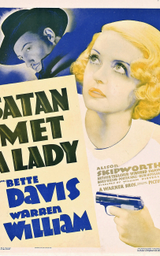

In [ ]:
image = np.rollaxis(images[0],0,3)
print(image.shape)
cv2_imshow(image+123)

In [ ]:
moviesDrama = []
for i in range(len(genres)):
  if genres[i][0] == 1 and genres[i][7] == 0:
    moviesDrama.append(i)
print(moviesDrama[0:10])
print(len(moviesDrama))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
13444


In [ ]:
moviesHorror = []
for i in range(len(genres)):
  if genres[i][7] == 1 and genres[i][0] == 0:
    moviesHorror.append(i)
print(moviesHorror[0:10])
print(len(moviesHorror))

[13, 57, 207, 218, 226, 244, 245, 250, 262, 274]
2180


In [ ]:
os.makedirs('/content/dataset')
os.makedirs('/content/dataset/horror')
os.makedirs('/content/dataset/drama')

In [ ]:
#0 if is Horror
#1 if is Drama
for i in range(4000):
  if i < 2000:
    image = np.rollaxis(images[moviesHorror[i]],0,3) + 123
    cv2.imwrite(os.path.join('/content/dataset/horror',str(i)+'.jpg'), image)
  else:
    image = np.rollaxis(images[moviesDrama[i]],0,3) + 123
    cv2.imwrite(os.path.join('/content/dataset/drama',str(i)+'.jpg'), image)

In [ ]:
train_dir = '/content/dataset'
datagen = ImageDataGenerator(validation_split=0.2) 

train_generator = datagen.flow_from_directory(train_dir,
                                             batch_size=32,
                                             target_size = (224,224), 
                                             #target_size=(256, 160),
                                             class_mode='binary',
                                             shuffle=True,
                                             subset = "training")

valid_generator = datagen.flow_from_directory(train_dir,
                                             batch_size=32,
                                             target_size = (224,224),
                                             #target_size=(256, 160),
                                             class_mode='binary',
                                             subset = "validation")

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


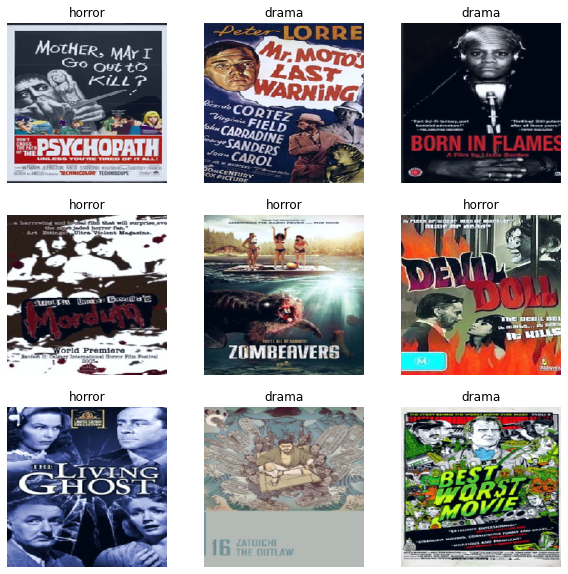

In [ ]:
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
images, labels = train_generator.next()   #Se obtiene la tupla siguiente del objeto iterator
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i]/255)
  plt.title(class_names[labels[i].astype("uint8")])
  plt.axis("off")

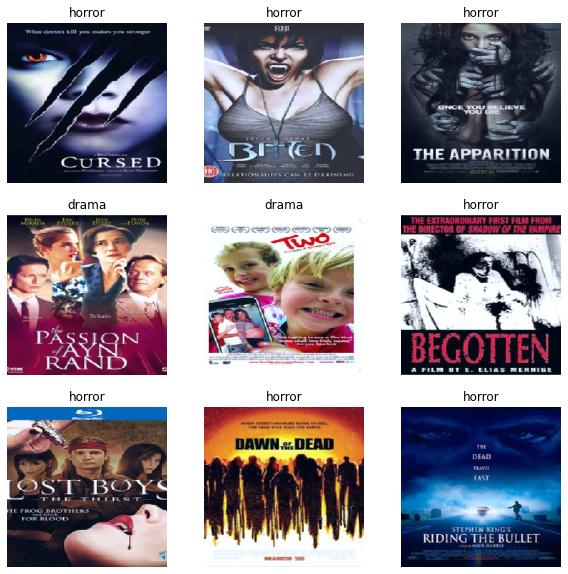

In [ ]:
plt.figure(figsize=(10, 10))
images, labels = valid_generator.next()
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i]/255)
  plt.title(class_names[labels[i].astype("uint8")])
  plt.axis("off")

In [ ]:
newTensor=tf.keras.Input(shape=train_generator.next()[0].shape[1:4])

#Se descarga VGG-16 sin incluir la capa superior para clasificar, definiendo el tensor de entrada
#y con pesos prenetrenados
base_model=tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),weights='imagenet')

#Se congela el modelo para solo entrenar las capas de arriba
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#Se extrae el batch de imagenes y sus labels como tuplas y se pasa por el modelo para 
#ver la forma del tensor de salida
image_batch, label_batch = train_generator.next()
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [ ]:
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
medium_layer = tf.keras.layers.Dense(320, activation = 'relu')
medium_batch = medium_layer(feature_batch_average)
print(medium_batch.shape)

(32, 320)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1,activation = 'sigmoid',name='main_output')
prediction_batch = prediction_layer(medium_batch)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#Se hace un clear a la sesion de Keras para que en pruebas para que no ponga modelos en el stack
tf.keras.backend.clear_session() 

#Se crea el modelo
inputs = tf.keras.Input(shape=train_generator.next()[0].shape[1:4])
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
x = medium_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Se usa un learning rate pequeño para hacer pruebas
base_learning_rate = 0.005
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               655680    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0     

In [ ]:
initial_epochs = 6
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

Epoch 1/6
100/100 [==============================] - 34s 302ms/step - loss: 2.2480 - accuracy: 0.6187 - val_loss: 0.5738 - val_accuracy: 0.7063
Epoch 2/6
100/100 [==============================] - 29s 291ms/step - loss: 0.5980 - accuracy: 0.6831 - val_loss: 0.5041 - val_accuracy: 0.7563
Epoch 3/6
100/100 [==============================] - 29s 291ms/step - loss: 0.5802 - accuracy: 0.6925 - val_loss: 0.5210 - val_accuracy: 0.7588
Epoch 4/6
100/100 [==============================] - 29s 290ms/step - loss: 0.5626 - accuracy: 0.6991 - val_loss: 0.5025 - val_accuracy: 0.7625
Epoch 5/6
100/100 [==============================] - 29s 291ms/step - loss: 0.5488 - accuracy: 0.7181 - val_loss: 0.5261 - val_accuracy: 0.7400
Epoch 6/6
100/100 [==============================] - 29s 290ms/step - loss: 0.5461 - accuracy: 0.7209 - val_loss: 0.5029 - val_accuracy: 0.7638


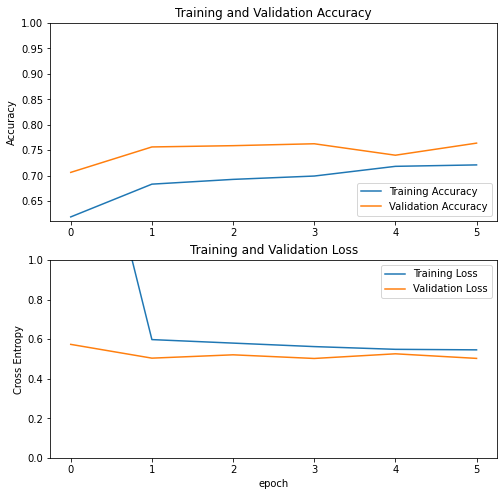

In [ ]:
#Se plotean las graficas del accuracy y de la función de perdida sin callbacks

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Se pone el modelo como completamente entrenable, se "descongela"
base_model.trainable = True

# Se observa cuantas capas tiene el modelo
print("Number of layers in the base model: ", len(base_model.layers))
print('\n')
# Se va a entrenar desde la capa 17 en adelante (Escogido mendiante pruebas)
fine_tune_at = 155

# Se congelan todas las capas anterior a fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/100),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Se especifica que el loss viene de logits
              metrics=['accuracy'])
model.summary()

Number of layers in the base model:  175


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               655680    
_________________________________________________________________
dropout (Dropout) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs

#del history_fine

#Se entrena desde siguiendo el entrenamiento anterior, es decir, empezando desde el 15
history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Epoch 6/13


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


100/100 [==============================] - 38s 339ms/step - loss: 0.5112 - accuracy: 0.7466 - val_loss: 0.4638 - val_accuracy: 0.7675
Epoch 7/13
100/100 [==============================] - 33s 327ms/step - loss: 0.3402 - accuracy: 0.8516 - val_loss: 0.5042 - val_accuracy: 0.7625
Epoch 8/13
100/100 [==============================] - 33s 328ms/step - loss: 0.1882 - accuracy: 0.9344 - val_loss: 0.5488 - val_accuracy: 0.7588
Epoch 9/13
100/100 [==============================] - 33s 329ms/step - loss: 0.1000 - accuracy: 0.9678 - val_loss: 0.6067 - val_accuracy: 0.7675
Epoch 10/13
100/100 [==============================] - 33s 328ms/step - loss: 0.0509 - accuracy: 0.9878 - val_loss: 0.7880 - val_accuracy: 0.7525
Epoch 11/13
100/100 [==============================] - 33s 327ms/step - loss: 0.0349 - accuracy: 0.9922 - val_loss: 0.8949 - val_accuracy: 0.7525
Epoch 12/13
100/100 [==============================] - 33s 328ms/step - loss: 0.0209 - accuracy: 0.9969 - val_loss: 0.8846 - val_accuracy: 

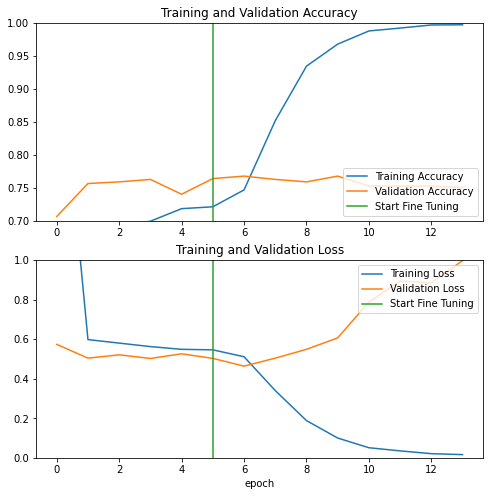

In [ ]:
#Finalmente se plotean las gráficas del entrenamiento

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()